### Experiments
1) Think token probing: 
    - Checking for the "think" token and its corresponding activations and training a probe on the residual stream activations to classify "think" or not.
    - Doing the same by probing sae latents and comparing the results.
    - Can use these latents and activations to steer the model - as in just resample them in cases where the think token hasn't been used and rerun on the same answer and check. 

2) Chinese and "think" correlation
    - Check if there are common sae latents that fire for the "think" token and Chinese characters.
    - Also check for the attention that these characters give to the "think" token.
    - Can we make the model to think forcefully when not required and check if it randomly generates things (i.e weak hallucination) or reflect back and stops answering.

3) Run addition and subtraction examples saved from Perplexity's thread, and probe classifiers on the residual stream and sae latents to check for a particular concept in the model.   

In [1]:
import torch as t
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, roc_auc_score
from torch.utils.data import TensorDataset, DataLoader
import seaborn as sns
import umap
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import nnsight
from tqdm import tqdm
import sys
from nnsight import LanguageModel
from safetensors.torch import load_file
import os
from dictionary_learning.dictionary import AutoEncoderNew, AutoEncoder

os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [2]:
llm = LanguageModel("deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B", device_map="auto")
print(llm)

Qwen2ForCausalLM(
  (model): Qwen2Model(
    (embed_tokens): Embedding(151936, 1536)
    (layers): ModuleList(
      (0-27): 28 x Qwen2DecoderLayer(
        (self_attn): Qwen2Attention(
          (q_proj): Linear(in_features=1536, out_features=1536, bias=True)
          (k_proj): Linear(in_features=1536, out_features=256, bias=True)
          (v_proj): Linear(in_features=1536, out_features=256, bias=True)
          (o_proj): Linear(in_features=1536, out_features=1536, bias=False)
        )
        (mlp): Qwen2MLP(
          (gate_proj): Linear(in_features=1536, out_features=8960, bias=False)
          (up_proj): Linear(in_features=1536, out_features=8960, bias=False)
          (down_proj): Linear(in_features=8960, out_features=1536, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): Qwen2RMSNorm((1536,), eps=1e-06)
        (post_attention_layernorm): Qwen2RMSNorm((1536,), eps=1e-06)
      )
    )
    (norm): Qwen2RMSNorm((1536,), eps=1e-06)
    (rotary_emb): Qw

In [3]:
act_dir_path = "/home/aansh/nnsightusage/Logs/Check_4_Chinese_outputs/Activations"
ans_dir_path = "/home/aansh/nnsightusage/Logs/Check_4_Chinese_outputs/Answers"
act_files = os.listdir(act_dir_path)
ans_files = os.listdir(ans_dir_path)
act_files.sort()
ans_files.sort()

In [4]:
def check_word_in_file(file_path: str, word: str) -> bool:
    with open(file_path, "r", encoding="utf-8") as file:
        text = file.read().strip()
    return word in text

count_num_thinks = 0
ans_think_filenames = []
for filename in ans_files:
    filePath = os.path.join(ans_dir_path, filename)
    if check_word_in_file(filePath, "</think>"):
        count_num_thinks += 1
        ans_think_filenames.append(filename)
        
print(count_num_thinks)
print(ans_think_filenames)

act_think_filenames = []
for ans_filename in ans_think_filenames:
    act_filename = ans_filename.replace("ans", "act")
    act_filename = act_filename.replace("txt", "pth")
    act_think_filenames.append(act_filename)
    
print(len(act_think_filenames))
print(act_think_filenames)

31
['ans_run_1.txt', 'ans_run_10.txt', 'ans_run_103.txt', 'ans_run_122.txt', 'ans_run_130.txt', 'ans_run_144.txt', 'ans_run_147.txt', 'ans_run_162.txt', 'ans_run_164.txt', 'ans_run_181.txt', 'ans_run_195.txt', 'ans_run_196.txt', 'ans_run_30.txt', 'ans_run_40.txt', 'ans_run_44.txt', 'ans_run_46.txt', 'ans_run_48.txt', 'ans_run_49.txt', 'ans_run_52.txt', 'ans_run_61.txt', 'ans_run_63.txt', 'ans_run_66.txt', 'ans_run_69.txt', 'ans_run_76.txt', 'ans_run_82.txt', 'ans_run_85.txt', 'ans_run_86.txt', 'ans_run_91.txt', 'ans_run_94.txt', 'ans_run_97.txt', 'ans_run_99.txt']
31
['act_run_1.pth', 'act_run_10.pth', 'act_run_103.pth', 'act_run_122.pth', 'act_run_130.pth', 'act_run_144.pth', 'act_run_147.pth', 'act_run_162.pth', 'act_run_164.pth', 'act_run_181.pth', 'act_run_195.pth', 'act_run_196.pth', 'act_run_30.pth', 'act_run_40.pth', 'act_run_44.pth', 'act_run_46.pth', 'act_run_48.pth', 'act_run_49.pth', 'act_run_52.pth', 'act_run_61.pth', 'act_run_63.pth', 'act_run_66.pth', 'act_run_69.pth', 'a

In [5]:
def rearrange_activations_mlp(hidden_states: dict):
    ls_activations = []
    for i in range(len(hidden_states)):
        first_token_acts = hidden_states[f"layer_{i}"]["mlp"][0]
        rest_token_acts = t.cat(hidden_states[f"layer_{i}"]["mlp"][1:], dim=1)
        all_acts = t.cat([first_token_acts, rest_token_acts], dim=1)
        ls_activations.append(all_acts)
    
    return t.cat(ls_activations, dim=0)

def get_think_token_position(ans_dir_path: str, ans_filename: str) -> int:
    ans_file_path = os.path.join(ans_dir_path, ans_filename)
    with open(ans_file_path, "r", encoding="utf-8") as file:
        text = file.read().strip()
    tokenized_text_ids = llm.tokenizer(text, return_tensors="pt", add_special_tokens=False)
    tokenized_text = llm.tokenizer.tokenize(text)
    think_token = "</think>"
    think_token_index = tokenized_text.index(think_token)
    return tokenized_text_ids, tokenized_text, think_token_index     

def get_think_token_mlp_activations(act_dir_path: str, act_filename: str) -> t.Tensor:
    act_file_path = os.path.join(act_dir_path, act_filename)
    hidden_states = t.load(act_file_path)
    return rearrange_activations_mlp(hidden_states)

In [6]:
ls_think_token_activations = []
for i, act_filename in tqdm(enumerate(act_think_filenames)):
    act_file_path = os.path.join(act_dir_path, act_filename)
    hidden_states = t.load(act_file_path)
    ans_filename = act_filename.replace("act", "ans")
    ans_filename = ans_filename.replace("pth", "txt")
    tokenized_text_ids, tokenized_text, think_token_index = get_think_token_position(ans_dir_path, ans_filename)
    mlp_activations = get_think_token_mlp_activations(act_dir_path, act_filename)
    think_token_mlp_activations = mlp_activations[:, think_token_index-1, :].unsqueeze(0)
    ls_think_token_activations.append(think_token_mlp_activations)
    
think_token_activations = t.cat(ls_think_token_activations, dim=0)

31it [08:44, 16.92s/it]


In [7]:
think_token_activations.shape

torch.Size([31, 28, 1536])

In [11]:
ls_non_think_token_activations = []
for i, act_filename in tqdm(enumerate(act_files)):
    if act_filename in act_think_filenames:
        continue
    hidden_states = t.load(act_file_path)
    token_index = t.randint(0, 200, (1, 1)).item()
    mlp_activations = get_think_token_mlp_activations(act_dir_path, act_filename)
    non_think_token_mlp_activations = mlp_activations[:, token_index, :].unsqueeze(0)
    ls_non_think_token_activations.append(non_think_token_mlp_activations)
   
non_think_token_activations = t.cat(ls_non_think_token_activations, dim=0) 

200it [49:09, 14.75s/it]


In [12]:
non_think_token_activations.shape

torch.Size([169, 28, 1536])

In [13]:
def load_sae(layer: int):
    weights_path = f"/home/aansh/nnsightusage/sae_model/layers.{layer}.mlp/sae.safetensors"
    activation_dim =  1536 
    dictionary_size = 65536 
    ae = AutoEncoder(activation_dim, dictionary_size)
    state_dict = load_file(weights_path)
    state_dict.keys()
    new_state_dict = {}
    for key in state_dict.keys():
        new_key = key  
        if key == "W_dec":
            new_key = "decoder.weight"
            new_state_dict[new_key] = state_dict[key].T  
        elif key == "b_dec":
            new_key = "bias"
        if key != "W_dec": 
            new_state_dict[new_key] = state_dict[key]  # Copy data to the new key

    ae.load_state_dict(new_state_dict)
    ae.cuda() 
    return ae 

In [14]:
sae = load_sae(0)
def get_sae_features(mlp_acts: t.Tensor, sae: AutoEncoder, layer: int = 0) -> t.Tensor:
    # sae = load_sae(layer)
    with t.no_grad():
        features = sae.encode(mlp_acts[:, layer, :].cuda())
    return features

In [15]:
think_token_latents = get_sae_features(think_token_activations, sae)
non_think_token_latents = get_sae_features(non_think_token_activations, sae)

print(think_token_latents.shape)
print(non_think_token_latents.shape)

torch.Size([31, 65536])
torch.Size([169, 65536])


(200, 65536)


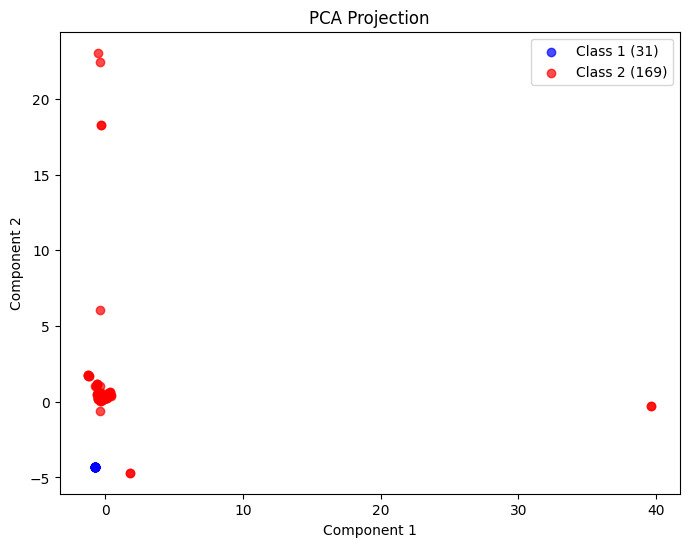

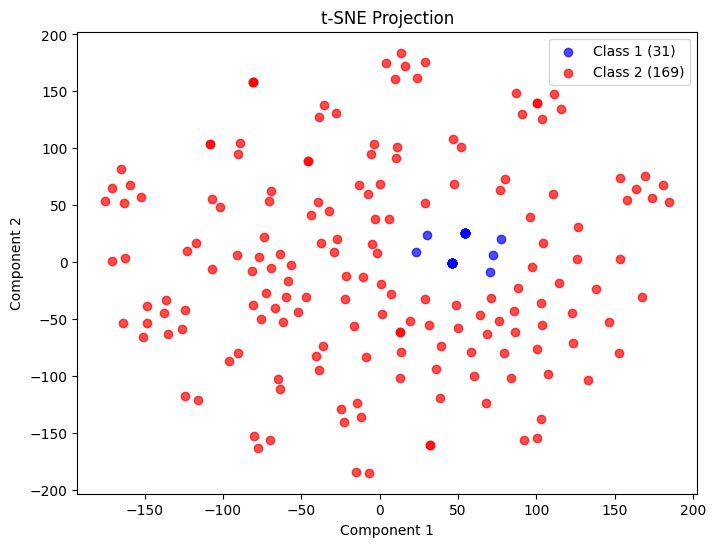

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap.umap_ as umap

# Generate dummy data (Replace these with actual data)
n_features = 100  # Replace with actual number of features
class_1 = think_token_latents.cpu().numpy()  # Shape (31, n_features)
class_2 = non_think_token_latents.cpu().numpy()  # Shape (169, n_features)

# Concatenate both classes
data = np.vstack((class_1, class_2))  # Shape (200, n_features)
print(data.shape)
labels = np.array([0] * 31 + [1] * 169)  # Labels (0 for class_1, 1 for class_2)

# Function to plot embeddings
def plot_embedding(embedded_data, title):
    plt.figure(figsize=(8, 6))
    plt.scatter(embedded_data[labels == 0, 0], embedded_data[labels == 0, 1], label="Class 1 (31)", alpha=0.7, color='blue')
    plt.scatter(embedded_data[labels == 1, 0], embedded_data[labels == 1, 1], label="Class 2 (169)", alpha=0.7, color='red')
    plt.legend()
    plt.title(title)
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.show()

# Apply PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(data)
plot_embedding(pca_result, "PCA Projection")

# Apply t-SNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
tsne_result = tsne.fit_transform(data)
plot_embedding(tsne_result, "t-SNE Projection")

# # Apply UMAP
# umap_proj = umap.UMAP(n_components=2, random_state=42).fit_transform(data)
# plt.scatter(umap_proj[:, 0], umap_proj[:, 1], c=labels, cmap='coolwarm', alpha=0.6)

In [17]:
think_token_latents_avg = think_token_latents.cpu().abs().mean(axis=0)
non_think_token_latents_avg = non_think_token_latents.cpu().abs().mean(axis=0)
think_token_latents_avg.shape

torch.Size([65536])

In [18]:
top_think_token_latents_indices = t.argsort(think_token_latents_avg, descending=True)
top_non_think_token_latents_indices = t.argsort(non_think_token_latents_avg, descending=True)
top_think_token_latents_indices, top_non_think_token_latents_indices

(tensor([25009,  9362, 16442,  ..., 21874, 21875, 21876]),
 tensor([29070, 53563, 62464,  ..., 25077, 25078, 25079]))

In [19]:
top_think_token_latents = think_token_latents[:, top_think_token_latents_indices[:10]]
top_non_think_token_latents = non_think_token_latents[:, top_non_think_token_latents_indices[:10]]

(200, 10)


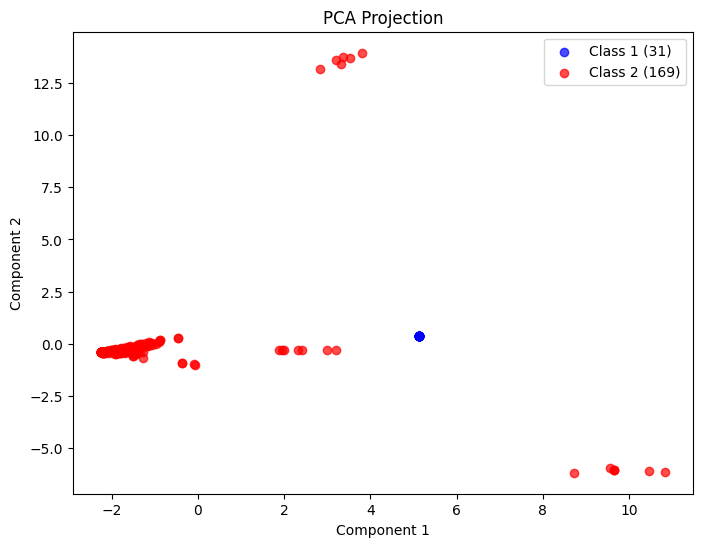

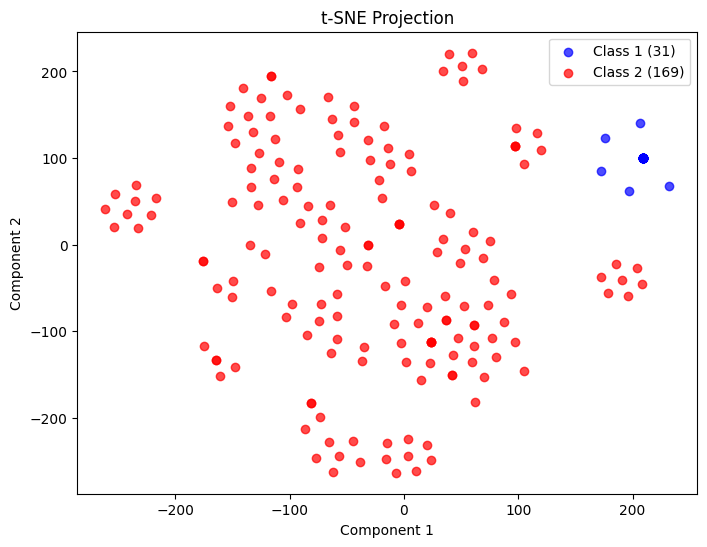

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap.umap_ as umap

# Generate dummy data (Replace these with actual data)
n_features = 100  # Replace with actual number of features
class_1 = top_think_token_latents.cpu().numpy()  # Shape (31, n_features)
class_2 = top_non_think_token_latents.cpu().numpy()  # Shape (169, n_features)

# Concatenate both classes
data = np.vstack((class_1, class_2))  # Shape (200, n_features)
print(data.shape)
labels = np.array([0] * 31 + [1] * 169)  # Labels (0 for class_1, 1 for class_2)

# Function to plot embeddings
def plot_embedding(embedded_data, title):
    plt.figure(figsize=(8, 6))
    plt.scatter(embedded_data[labels == 0, 0], embedded_data[labels == 0, 1], label="Class 1 (31)", alpha=0.7, color='blue')
    plt.scatter(embedded_data[labels == 1, 0], embedded_data[labels == 1, 1], label="Class 2 (169)", alpha=0.7, color='red')
    plt.legend()
    plt.title(title)
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.show()

# Apply PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(data)
plot_embedding(pca_result, "PCA Projection")

# Apply t-SNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
tsne_result = tsne.fit_transform(data)
plot_embedding(tsne_result, "t-SNE Projection")

# # Apply UMAP
# umap_proj = umap.UMAP(n_components=2, random_state=42).fit_transform(data)
# plt.scatter(umap_proj[:, 0], umap_proj[:, 1], c=labels, cmap='coolwarm', alpha=0.6)

## Executive Summary
1) Probing the CoT for different things:
    - Probing for the "think" token is easy and the token is classifiable both when probing the residual stream and the sae basis. Corresponding analysis and graphs can be shown. This was sort of token level probing.
    - Probing for language switch (i.e Chinese Language), this also shows reasonable results and used these top 1% activations at different layers to reproduce or ***steer the model*** to produce more Chinese outputs. The steering here is better at the SAE level. Note one can argue that this too is token level probing, however there are given SAE latents that correspond to not only a partular Chinese token but a lot of them, which get activated here, similarly neurons that get activated, seems like this language level feature is also easily probable, can't decide which of the above two setups was difficult.   
    - Probing for a particular math concept, addition and subtraction prompts.
    - Probing for if we can make out from the activations if a given problem was difficult or easy, also cached the time (latency) for each response here to check, since there should be a clear correlation, if the question is difficult -> it takes more time -> check if this reflects in the activations. Sort of works, i.e activations of the first couple of layers show clear correlation, the others are somewhat cloudy and not strongly correlated.
    - Probed for stop words using an LLM, i.e words that show or rather induce behaviour in the model to think more by revisiting and checking what they have done is right. However, couldn't think of how to construct steering vectors here, without making the model hallucinate. This sort of forced hallucination can be used for studying jailbreaks, but felt that I was deviating from my original question of what all can be probed for in the CoT, so traced back to this.

2) Failed Experiments
    - Checked for gradient bursts and variance in activation entropy in the neighbourhood of these stop words, couldn't find results that would show expected behaviour. 
    - Tried to check for discrete phase transitions in a model's answer, i.e say a thinking and understanding phase, a making a plan stage, an answering stage and a concluding stage, although these things are clearly visible in the final answer, not tractable, had low expectations going in on this, was hoping to find atleast something interesting but couldn't though. 
    - Could have checked for models that use test-time training/ test-time compute for this behaviour since if we can explicitly mention to it a given amount of context window, it ultimately understands the depth of answer we expect from it.          
    - Also stumbled upon the fact that sometimes probing the residual stream is better than probing the sae basis, was not sure why and wanted to explore but felt like deviating from the topic too much and then ultimately found this as a problem listed in the MATS 7.0 problem sheet, kinda interesting! 
    - Also tried a good amount of attention pattern analysis to check if the stop words and the think token attend to some particular things throughout the text, but couldn't find anything here as well, also Rotatory Embeddings are as sad as it gets for interpretability, didn't bother to find a workaround here or read about work done on this.   



In [21]:
# def generate_output(llm: LanguageModel,
#                     prompt:str,
#                     append_eos_token: bool = True,
#                     n_new_tokens:int = 200,
#                     temperature: float = 1,
#                     print_ans: bool = True,
#                     save_ans: bool = False, 
#                     ans_filename: str = "ans.txt",
#                     ans_dir_path: str = "/home/aansh/nnsightusage/Logs/Check_4_Chinese_outputs/Answers",
#                     save_activations: bool = False,
#                     act_filename: str = "acts.pth",
#                     act_dir_path: str = "/home/aansh/nnsightusage/Logs/Check_4_Chinese_outputs/Activations"):
    
#     if append_eos_token:
#         prompt += llm.tokenizer.eos_token
    
#     with llm.generate(prompt, max_new_tokens=n_new_tokens, temperature=temperature) as tracer:
#         hidden_states = nnsight.dict().save()
#         for i in range(len(llm.model.layers)):
#             hidden_states[f"layer_{i}"] = {
#                 "mlp": [],
#                 "q_proj": [],
#                 "k_proj": [],
#             }
#         llm.model.layers.all()
#         for i in range(len(llm.model.layers)):
#             hidden_states[f"layer_{i}"]["mlp"].append(llm.model.layers[i].mlp.output.cpu())
#             hidden_states[f"layer_{i}"]["q_proj"].append(llm.model.layers[i].self_attn.q_proj.output.cpu())
#             hidden_states[f"layer_{i}"]["k_proj"].append(llm.model.layers[i].self_attn.k_proj.output.cpu())
#         out = llm.generator.output.cpu().save()
        
#     decoded_prompt = llm.tokenizer.decode(out[0][0:50])
#     decoded_answer = llm.tokenizer.decode(out[0][:])
    
#     if print_ans:
#         print(f"Prompt: {decoded_prompt}")
#         print(f"Generated Answer: {decoded_answer}")
        
#     if save_ans:
#         save_text_to_file(decoded_answer, ans_filename, ans_dir_path)
        
#     if save_activations:
#         save_acts_to_file(hidden_states, act_filename, act_dir_path)

In [22]:
def save_text_to_file(text: dict,
                      filename:str,
                      dir_path: str):
    
    os.makedirs(dir_path, exist_ok=True)  
    file_path = os.path.join(dir_path, filename)  
    with open(file_path, "w", encoding="utf-8") as file:
        file.write(text)
    print(f"File saved at: {file_path}")

In [36]:
def steer_with_sae_latents(llm: LanguageModel,
                           prompt: str, 
                           append_eos_token: bool = True,
                           n_new_tokens: int = 200,
                           temperature: float = 1,
                           print_ans: bool = False,
                           save_ans: bool = False,
                           ans_filename: str = "ans.txt",
                           ans_dir_path: str = "/home/aansh/nnsightusage/NewExperiments/Logs/Experiment_2_sae_steering/Answers_2plus2",
                           save_activations: bool = False,
                           act_filename: str = "acts.pth",
                           act_dir_path: str = "/home/aansh/nnsightusage/Logs/Check_4_Chinese_outputs/Activations",
                           sae: AutoEncoder = None,
                           layer: int = 10, 
                           top_think_token_latents_indices: list = top_think_token_latents_indices,
                           top_k_indices: int = 20,
                           scaling_factor: int = 5):
    
    if append_eos_token:
        prompt += llm.tokenizer.eos_token
        
    with llm.generate(prompt, max_new_tokens=n_new_tokens, temperature=temperature) as tracer:
        for i in range(n_new_tokens):
            if i==0:
                lt_output = llm.model.layers[layer].mlp.output.cpu()
                lt_latents = sae.encode(lt_output[:, -1, :].cuda())
                for j in top_think_token_latents_indices[:top_k_indices]:
                    lt_latents[0][j] = lt_latents[0][j] * scaling_factor
                    
                lt_output = sae.decode(lt_latents)
                llm.model.layers[layer].mlp.output[:, -1, :] = lt_output
                
        out = llm.generator.output.cpu().save()
        
    decoded_answer = llm.tokenizer.decode(out[0][:])
    
    if print_ans:
        print(f"Generated Answer: {decoded_answer}")
        
    if save_ans:
        save_text_to_file(decoded_answer, ans_filename, ans_dir_path)

In [37]:
prompt = """
What is 2+2?
"""

In [38]:
for i in range(100):
    print(f"Steering Experiment: {i}")
    steer_with_sae_latents(llm, prompt, sae=sae, save_ans=True, layer=0, ans_filename=f"ans_{i}.txt")

Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Steering Experiment: 0


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


File saved at: /home/aansh/nnsightusage/NewExperiments/Logs/Experiment_2_sae_steering/Answers_2plus2/ans_0.txt
Steering Experiment: 1


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


File saved at: /home/aansh/nnsightusage/NewExperiments/Logs/Experiment_2_sae_steering/Answers_2plus2/ans_1.txt
Steering Experiment: 2


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


File saved at: /home/aansh/nnsightusage/NewExperiments/Logs/Experiment_2_sae_steering/Answers_2plus2/ans_2.txt
Steering Experiment: 3


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


File saved at: /home/aansh/nnsightusage/NewExperiments/Logs/Experiment_2_sae_steering/Answers_2plus2/ans_3.txt
Steering Experiment: 4


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


File saved at: /home/aansh/nnsightusage/NewExperiments/Logs/Experiment_2_sae_steering/Answers_2plus2/ans_4.txt
Steering Experiment: 5


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


File saved at: /home/aansh/nnsightusage/NewExperiments/Logs/Experiment_2_sae_steering/Answers_2plus2/ans_5.txt
Steering Experiment: 6


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


File saved at: /home/aansh/nnsightusage/NewExperiments/Logs/Experiment_2_sae_steering/Answers_2plus2/ans_6.txt
Steering Experiment: 7
File saved at: /home/aansh/nnsightusage/NewExperiments/Logs/Experiment_2_sae_steering/Answers_2plus2/ans_7.txt
Steering Experiment: 8


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


File saved at: /home/aansh/nnsightusage/NewExperiments/Logs/Experiment_2_sae_steering/Answers_2plus2/ans_8.txt
Steering Experiment: 9


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


File saved at: /home/aansh/nnsightusage/NewExperiments/Logs/Experiment_2_sae_steering/Answers_2plus2/ans_9.txt
Steering Experiment: 10


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


File saved at: /home/aansh/nnsightusage/NewExperiments/Logs/Experiment_2_sae_steering/Answers_2plus2/ans_10.txt
Steering Experiment: 11


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


File saved at: /home/aansh/nnsightusage/NewExperiments/Logs/Experiment_2_sae_steering/Answers_2plus2/ans_11.txt
Steering Experiment: 12


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


File saved at: /home/aansh/nnsightusage/NewExperiments/Logs/Experiment_2_sae_steering/Answers_2plus2/ans_12.txt
Steering Experiment: 13


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


File saved at: /home/aansh/nnsightusage/NewExperiments/Logs/Experiment_2_sae_steering/Answers_2plus2/ans_13.txt
Steering Experiment: 14


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


File saved at: /home/aansh/nnsightusage/NewExperiments/Logs/Experiment_2_sae_steering/Answers_2plus2/ans_14.txt
Steering Experiment: 15


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


File saved at: /home/aansh/nnsightusage/NewExperiments/Logs/Experiment_2_sae_steering/Answers_2plus2/ans_15.txt
Steering Experiment: 16


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


File saved at: /home/aansh/nnsightusage/NewExperiments/Logs/Experiment_2_sae_steering/Answers_2plus2/ans_16.txt
Steering Experiment: 17


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


File saved at: /home/aansh/nnsightusage/NewExperiments/Logs/Experiment_2_sae_steering/Answers_2plus2/ans_17.txt
Steering Experiment: 18


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


File saved at: /home/aansh/nnsightusage/NewExperiments/Logs/Experiment_2_sae_steering/Answers_2plus2/ans_18.txt
Steering Experiment: 19


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


File saved at: /home/aansh/nnsightusage/NewExperiments/Logs/Experiment_2_sae_steering/Answers_2plus2/ans_19.txt
Steering Experiment: 20


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


File saved at: /home/aansh/nnsightusage/NewExperiments/Logs/Experiment_2_sae_steering/Answers_2plus2/ans_20.txt
Steering Experiment: 21


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


File saved at: /home/aansh/nnsightusage/NewExperiments/Logs/Experiment_2_sae_steering/Answers_2plus2/ans_21.txt
Steering Experiment: 22


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


File saved at: /home/aansh/nnsightusage/NewExperiments/Logs/Experiment_2_sae_steering/Answers_2plus2/ans_22.txt
Steering Experiment: 23


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


File saved at: /home/aansh/nnsightusage/NewExperiments/Logs/Experiment_2_sae_steering/Answers_2plus2/ans_23.txt
Steering Experiment: 24


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


File saved at: /home/aansh/nnsightusage/NewExperiments/Logs/Experiment_2_sae_steering/Answers_2plus2/ans_24.txt
Steering Experiment: 25


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


File saved at: /home/aansh/nnsightusage/NewExperiments/Logs/Experiment_2_sae_steering/Answers_2plus2/ans_25.txt
Steering Experiment: 26


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


File saved at: /home/aansh/nnsightusage/NewExperiments/Logs/Experiment_2_sae_steering/Answers_2plus2/ans_26.txt
Steering Experiment: 27


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


File saved at: /home/aansh/nnsightusage/NewExperiments/Logs/Experiment_2_sae_steering/Answers_2plus2/ans_27.txt
Steering Experiment: 28
File saved at: /home/aansh/nnsightusage/NewExperiments/Logs/Experiment_2_sae_steering/Answers_2plus2/ans_28.txt
Steering Experiment: 29


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


File saved at: /home/aansh/nnsightusage/NewExperiments/Logs/Experiment_2_sae_steering/Answers_2plus2/ans_29.txt
Steering Experiment: 30


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


File saved at: /home/aansh/nnsightusage/NewExperiments/Logs/Experiment_2_sae_steering/Answers_2plus2/ans_30.txt
Steering Experiment: 31


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


File saved at: /home/aansh/nnsightusage/NewExperiments/Logs/Experiment_2_sae_steering/Answers_2plus2/ans_31.txt
Steering Experiment: 32


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


File saved at: /home/aansh/nnsightusage/NewExperiments/Logs/Experiment_2_sae_steering/Answers_2plus2/ans_32.txt
Steering Experiment: 33


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


File saved at: /home/aansh/nnsightusage/NewExperiments/Logs/Experiment_2_sae_steering/Answers_2plus2/ans_33.txt
Steering Experiment: 34


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


File saved at: /home/aansh/nnsightusage/NewExperiments/Logs/Experiment_2_sae_steering/Answers_2plus2/ans_34.txt
Steering Experiment: 35


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


File saved at: /home/aansh/nnsightusage/NewExperiments/Logs/Experiment_2_sae_steering/Answers_2plus2/ans_35.txt
Steering Experiment: 36


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


File saved at: /home/aansh/nnsightusage/NewExperiments/Logs/Experiment_2_sae_steering/Answers_2plus2/ans_36.txt
Steering Experiment: 37


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


File saved at: /home/aansh/nnsightusage/NewExperiments/Logs/Experiment_2_sae_steering/Answers_2plus2/ans_37.txt
Steering Experiment: 38


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


File saved at: /home/aansh/nnsightusage/NewExperiments/Logs/Experiment_2_sae_steering/Answers_2plus2/ans_38.txt
Steering Experiment: 39


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


File saved at: /home/aansh/nnsightusage/NewExperiments/Logs/Experiment_2_sae_steering/Answers_2plus2/ans_39.txt
Steering Experiment: 40


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


File saved at: /home/aansh/nnsightusage/NewExperiments/Logs/Experiment_2_sae_steering/Answers_2plus2/ans_40.txt
Steering Experiment: 41


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


File saved at: /home/aansh/nnsightusage/NewExperiments/Logs/Experiment_2_sae_steering/Answers_2plus2/ans_41.txt
Steering Experiment: 42


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


File saved at: /home/aansh/nnsightusage/NewExperiments/Logs/Experiment_2_sae_steering/Answers_2plus2/ans_42.txt
Steering Experiment: 43


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


File saved at: /home/aansh/nnsightusage/NewExperiments/Logs/Experiment_2_sae_steering/Answers_2plus2/ans_43.txt
Steering Experiment: 44


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


File saved at: /home/aansh/nnsightusage/NewExperiments/Logs/Experiment_2_sae_steering/Answers_2plus2/ans_44.txt
Steering Experiment: 45


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


File saved at: /home/aansh/nnsightusage/NewExperiments/Logs/Experiment_2_sae_steering/Answers_2plus2/ans_45.txt
Steering Experiment: 46


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


File saved at: /home/aansh/nnsightusage/NewExperiments/Logs/Experiment_2_sae_steering/Answers_2plus2/ans_46.txt
Steering Experiment: 47


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


File saved at: /home/aansh/nnsightusage/NewExperiments/Logs/Experiment_2_sae_steering/Answers_2plus2/ans_47.txt
Steering Experiment: 48


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


File saved at: /home/aansh/nnsightusage/NewExperiments/Logs/Experiment_2_sae_steering/Answers_2plus2/ans_48.txt
Steering Experiment: 49


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


File saved at: /home/aansh/nnsightusage/NewExperiments/Logs/Experiment_2_sae_steering/Answers_2plus2/ans_49.txt
Steering Experiment: 50


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


File saved at: /home/aansh/nnsightusage/NewExperiments/Logs/Experiment_2_sae_steering/Answers_2plus2/ans_50.txt
Steering Experiment: 51


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


File saved at: /home/aansh/nnsightusage/NewExperiments/Logs/Experiment_2_sae_steering/Answers_2plus2/ans_51.txt
Steering Experiment: 52


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


File saved at: /home/aansh/nnsightusage/NewExperiments/Logs/Experiment_2_sae_steering/Answers_2plus2/ans_52.txt
Steering Experiment: 53


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


File saved at: /home/aansh/nnsightusage/NewExperiments/Logs/Experiment_2_sae_steering/Answers_2plus2/ans_53.txt
Steering Experiment: 54


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


File saved at: /home/aansh/nnsightusage/NewExperiments/Logs/Experiment_2_sae_steering/Answers_2plus2/ans_54.txt
Steering Experiment: 55


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


File saved at: /home/aansh/nnsightusage/NewExperiments/Logs/Experiment_2_sae_steering/Answers_2plus2/ans_55.txt
Steering Experiment: 56


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


File saved at: /home/aansh/nnsightusage/NewExperiments/Logs/Experiment_2_sae_steering/Answers_2plus2/ans_56.txt
Steering Experiment: 57


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


File saved at: /home/aansh/nnsightusage/NewExperiments/Logs/Experiment_2_sae_steering/Answers_2plus2/ans_57.txt
Steering Experiment: 58


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


File saved at: /home/aansh/nnsightusage/NewExperiments/Logs/Experiment_2_sae_steering/Answers_2plus2/ans_58.txt
Steering Experiment: 59


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


File saved at: /home/aansh/nnsightusage/NewExperiments/Logs/Experiment_2_sae_steering/Answers_2plus2/ans_59.txt
Steering Experiment: 60


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


File saved at: /home/aansh/nnsightusage/NewExperiments/Logs/Experiment_2_sae_steering/Answers_2plus2/ans_60.txt
Steering Experiment: 61


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


File saved at: /home/aansh/nnsightusage/NewExperiments/Logs/Experiment_2_sae_steering/Answers_2plus2/ans_61.txt
Steering Experiment: 62


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


File saved at: /home/aansh/nnsightusage/NewExperiments/Logs/Experiment_2_sae_steering/Answers_2plus2/ans_62.txt
Steering Experiment: 63


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


File saved at: /home/aansh/nnsightusage/NewExperiments/Logs/Experiment_2_sae_steering/Answers_2plus2/ans_63.txt
Steering Experiment: 64


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


File saved at: /home/aansh/nnsightusage/NewExperiments/Logs/Experiment_2_sae_steering/Answers_2plus2/ans_64.txt
Steering Experiment: 65


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


File saved at: /home/aansh/nnsightusage/NewExperiments/Logs/Experiment_2_sae_steering/Answers_2plus2/ans_65.txt
Steering Experiment: 66


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


File saved at: /home/aansh/nnsightusage/NewExperiments/Logs/Experiment_2_sae_steering/Answers_2plus2/ans_66.txt
Steering Experiment: 67


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


File saved at: /home/aansh/nnsightusage/NewExperiments/Logs/Experiment_2_sae_steering/Answers_2plus2/ans_67.txt
Steering Experiment: 68


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


File saved at: /home/aansh/nnsightusage/NewExperiments/Logs/Experiment_2_sae_steering/Answers_2plus2/ans_68.txt
Steering Experiment: 69


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


File saved at: /home/aansh/nnsightusage/NewExperiments/Logs/Experiment_2_sae_steering/Answers_2plus2/ans_69.txt
Steering Experiment: 70


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


File saved at: /home/aansh/nnsightusage/NewExperiments/Logs/Experiment_2_sae_steering/Answers_2plus2/ans_70.txt
Steering Experiment: 71


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


File saved at: /home/aansh/nnsightusage/NewExperiments/Logs/Experiment_2_sae_steering/Answers_2plus2/ans_71.txt
Steering Experiment: 72


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


File saved at: /home/aansh/nnsightusage/NewExperiments/Logs/Experiment_2_sae_steering/Answers_2plus2/ans_72.txt
Steering Experiment: 73


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


File saved at: /home/aansh/nnsightusage/NewExperiments/Logs/Experiment_2_sae_steering/Answers_2plus2/ans_73.txt
Steering Experiment: 74


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


File saved at: /home/aansh/nnsightusage/NewExperiments/Logs/Experiment_2_sae_steering/Answers_2plus2/ans_74.txt
Steering Experiment: 75


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


File saved at: /home/aansh/nnsightusage/NewExperiments/Logs/Experiment_2_sae_steering/Answers_2plus2/ans_75.txt
Steering Experiment: 76


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


File saved at: /home/aansh/nnsightusage/NewExperiments/Logs/Experiment_2_sae_steering/Answers_2plus2/ans_76.txt
Steering Experiment: 77


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


File saved at: /home/aansh/nnsightusage/NewExperiments/Logs/Experiment_2_sae_steering/Answers_2plus2/ans_77.txt
Steering Experiment: 78


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


File saved at: /home/aansh/nnsightusage/NewExperiments/Logs/Experiment_2_sae_steering/Answers_2plus2/ans_78.txt
Steering Experiment: 79


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


File saved at: /home/aansh/nnsightusage/NewExperiments/Logs/Experiment_2_sae_steering/Answers_2plus2/ans_79.txt
Steering Experiment: 80


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


File saved at: /home/aansh/nnsightusage/NewExperiments/Logs/Experiment_2_sae_steering/Answers_2plus2/ans_80.txt
Steering Experiment: 81


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


File saved at: /home/aansh/nnsightusage/NewExperiments/Logs/Experiment_2_sae_steering/Answers_2plus2/ans_81.txt
Steering Experiment: 82


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


File saved at: /home/aansh/nnsightusage/NewExperiments/Logs/Experiment_2_sae_steering/Answers_2plus2/ans_82.txt
Steering Experiment: 83


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


File saved at: /home/aansh/nnsightusage/NewExperiments/Logs/Experiment_2_sae_steering/Answers_2plus2/ans_83.txt
Steering Experiment: 84


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


File saved at: /home/aansh/nnsightusage/NewExperiments/Logs/Experiment_2_sae_steering/Answers_2plus2/ans_84.txt
Steering Experiment: 85


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


File saved at: /home/aansh/nnsightusage/NewExperiments/Logs/Experiment_2_sae_steering/Answers_2plus2/ans_85.txt
Steering Experiment: 86


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


File saved at: /home/aansh/nnsightusage/NewExperiments/Logs/Experiment_2_sae_steering/Answers_2plus2/ans_86.txt
Steering Experiment: 87


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


File saved at: /home/aansh/nnsightusage/NewExperiments/Logs/Experiment_2_sae_steering/Answers_2plus2/ans_87.txt
Steering Experiment: 88
File saved at: /home/aansh/nnsightusage/NewExperiments/Logs/Experiment_2_sae_steering/Answers_2plus2/ans_88.txt
Steering Experiment: 89


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


File saved at: /home/aansh/nnsightusage/NewExperiments/Logs/Experiment_2_sae_steering/Answers_2plus2/ans_89.txt
Steering Experiment: 90


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


File saved at: /home/aansh/nnsightusage/NewExperiments/Logs/Experiment_2_sae_steering/Answers_2plus2/ans_90.txt
Steering Experiment: 91


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


File saved at: /home/aansh/nnsightusage/NewExperiments/Logs/Experiment_2_sae_steering/Answers_2plus2/ans_91.txt
Steering Experiment: 92


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


File saved at: /home/aansh/nnsightusage/NewExperiments/Logs/Experiment_2_sae_steering/Answers_2plus2/ans_92.txt
Steering Experiment: 93


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


File saved at: /home/aansh/nnsightusage/NewExperiments/Logs/Experiment_2_sae_steering/Answers_2plus2/ans_93.txt
Steering Experiment: 94


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


File saved at: /home/aansh/nnsightusage/NewExperiments/Logs/Experiment_2_sae_steering/Answers_2plus2/ans_94.txt
Steering Experiment: 95


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


File saved at: /home/aansh/nnsightusage/NewExperiments/Logs/Experiment_2_sae_steering/Answers_2plus2/ans_95.txt
Steering Experiment: 96


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


File saved at: /home/aansh/nnsightusage/NewExperiments/Logs/Experiment_2_sae_steering/Answers_2plus2/ans_96.txt
Steering Experiment: 97


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


File saved at: /home/aansh/nnsightusage/NewExperiments/Logs/Experiment_2_sae_steering/Answers_2plus2/ans_97.txt
Steering Experiment: 98


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


File saved at: /home/aansh/nnsightusage/NewExperiments/Logs/Experiment_2_sae_steering/Answers_2plus2/ans_98.txt
Steering Experiment: 99
File saved at: /home/aansh/nnsightusage/NewExperiments/Logs/Experiment_2_sae_steering/Answers_2plus2/ans_99.txt


In [31]:
steered_ans_dir_path = "/home/aansh/nnsightusage/NewExperiments/Logs/Experiment_2_sae_steering/Answers"
steered_ans_files = os.listdir(steered_ans_dir_path)
steered_ans_files.sort()

count = 0
for filename in steered_ans_files:
    filePath = os.path.join(steered_ans_dir_path, filename)
    with open(filePath, "r", encoding="utf-8") as file:
        text = file.read().strip()
    
    if "</think>" in text:
        count += 1
    
print(count)

78


In [39]:
steered_ans_dir_path = "/home/aansh/nnsightusage/NewExperiments/Logs/Experiment_2_sae_steering/Answers_2plus2"
steered_ans_files = os.listdir(steered_ans_dir_path)
steered_ans_files.sort()

count = 0
for filename in steered_ans_files:
    filePath = os.path.join(steered_ans_dir_path, filename)
    with open(filePath, "r", encoding="utf-8") as file:
        text = file.read().strip()
    
    if "</think>" in text:
        count += 1
    
print(count)

100


In [41]:
# def steer_with_sae_latents(llm: LanguageModel,
#                            prompt: str, 
#                            append_eos_token: bool = True,
#                            n_new_tokens: int = 200,
#                            temperature: float = 1,
#                            print_ans: bool = False,
#                            save_ans: bool = False,
#                            ans_filename: str = "ans.txt",
#                            ans_dir_path: str = "/home/aansh/nnsightusage/NewExperiments/Logs/Experiment_2_sae_steering/Answers_2plus2",
#                            save_activations: bool = False,
#                            act_filename: str = "acts.pth",
#                            act_dir_path: str = "/home/aansh/nnsightusage/Logs/Check_4_Chinese_outputs/Activations",
#                            sae: AutoEncoder = None,
#                            layer: int = 10, 
#                            top_think_token_latents_indices: list = top_think_token_latents_indices,
#                            top_k_indices: int = 20,
#                            scaling_factor: int = 5):
    
#     if append_eos_token:
#         prompt += llm.tokenizer.eos_token
        
#     with llm.generate(prompt, max_new_tokens=n_new_tokens, temperature=temperature) as tracer:
#         for i in range(n_new_tokens):
#             if i==0:
#                 lt_output = llm.model.layers[layer].mlp.output.cpu()
#                 lt_latents = sae.encode(lt_output[:, -1, :].cuda())
#                 for j in top_think_token_latents_indices[:top_k_indices]:
#                     lt_latents[0][j] = lt_latents[0][j] * scaling_factor
                    
#                 lt_output = sae.decode(lt_latents)
#                 llm.model.layers[layer].mlp.output[:, -1, :] = lt_output
                
#         out = llm.generator.output.cpu().save()
        
#     decoded_answer = llm.tokenizer.decode(out[0][:])
    
#     if print_ans:
#         print(f"Generated Answer: {decoded_answer}")
        
#     if save_ans:
#         save_text_to_file(decoded_answer, ans_filename, ans_dir_path)

In [42]:
prompt = """
What is 2+2?
"""

In [44]:
def generate_output(llm: LanguageModel,
                    prompt:str,
                    append_eos_token: bool = True,
                    n_new_tokens:int = 200,
                    temperature: float = 1,
                    print_ans: bool = True,
                    save_ans: bool = False, 
                    ans_filename: str = "ans.txt",
                    ans_dir_path: str = "/home/aansh/nnsightusage/NewExperiments/Logs/Experiment_2_sae_steering/Answers_2plus2_pure",
                    save_activations: bool = False,
                    act_filename: str = "acts.pth",
                    act_dir_path: str = "/home/aansh/nnsightusage/Logs/Check_4_Chinese_outputs/Activations"):
    
    if append_eos_token:
        prompt += llm.tokenizer.eos_token
    
    with llm.generate(prompt, max_new_tokens=n_new_tokens, temperature=temperature) as tracer:
        out = llm.generator.output.cpu().save()
        
    decoded_prompt = llm.tokenizer.decode(out[0][0:50])
    decoded_answer = llm.tokenizer.decode(out[0][:])
    
    if print_ans:
        print(f"Prompt: {decoded_prompt}")
        print(f"Generated Answer: {decoded_answer}")
        
    if save_ans:
        save_text_to_file(decoded_answer, ans_filename, ans_dir_path)

In [47]:
llm_2 = LanguageModel("deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B", device_map="auto")
print(llm_2)

Qwen2ForCausalLM(
  (model): Qwen2Model(
    (embed_tokens): Embedding(151936, 1536)
    (layers): ModuleList(
      (0-27): 28 x Qwen2DecoderLayer(
        (self_attn): Qwen2Attention(
          (q_proj): Linear(in_features=1536, out_features=1536, bias=True)
          (k_proj): Linear(in_features=1536, out_features=256, bias=True)
          (v_proj): Linear(in_features=1536, out_features=256, bias=True)
          (o_proj): Linear(in_features=1536, out_features=1536, bias=False)
        )
        (mlp): Qwen2MLP(
          (gate_proj): Linear(in_features=1536, out_features=8960, bias=False)
          (up_proj): Linear(in_features=1536, out_features=8960, bias=False)
          (down_proj): Linear(in_features=8960, out_features=1536, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): Qwen2RMSNorm((1536,), eps=1e-06)
        (post_attention_layernorm): Qwen2RMSNorm((1536,), eps=1e-06)
      )
    )
    (norm): Qwen2RMSNorm((1536,), eps=1e-06)
    (rotary_emb): Qw

In [49]:
for i in range(100):
    print(f"Steering Experiment: {i}")
    generate_output(llm_2, prompt, print_ans=False, save_ans=True, ans_filename=f"ans_{i}.txt")

Steering Experiment: 0


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


File saved at: /home/aansh/nnsightusage/NewExperiments/Logs/Experiment_2_sae_steering/Answers_2plus2_pure/ans_0.txt
Steering Experiment: 1


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


File saved at: /home/aansh/nnsightusage/NewExperiments/Logs/Experiment_2_sae_steering/Answers_2plus2_pure/ans_1.txt
Steering Experiment: 2


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


File saved at: /home/aansh/nnsightusage/NewExperiments/Logs/Experiment_2_sae_steering/Answers_2plus2_pure/ans_2.txt
Steering Experiment: 3


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


File saved at: /home/aansh/nnsightusage/NewExperiments/Logs/Experiment_2_sae_steering/Answers_2plus2_pure/ans_3.txt
Steering Experiment: 4


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


File saved at: /home/aansh/nnsightusage/NewExperiments/Logs/Experiment_2_sae_steering/Answers_2plus2_pure/ans_4.txt
Steering Experiment: 5


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


File saved at: /home/aansh/nnsightusage/NewExperiments/Logs/Experiment_2_sae_steering/Answers_2plus2_pure/ans_5.txt
Steering Experiment: 6


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


File saved at: /home/aansh/nnsightusage/NewExperiments/Logs/Experiment_2_sae_steering/Answers_2plus2_pure/ans_6.txt
Steering Experiment: 7


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


File saved at: /home/aansh/nnsightusage/NewExperiments/Logs/Experiment_2_sae_steering/Answers_2plus2_pure/ans_7.txt
Steering Experiment: 8


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


File saved at: /home/aansh/nnsightusage/NewExperiments/Logs/Experiment_2_sae_steering/Answers_2plus2_pure/ans_8.txt
Steering Experiment: 9


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


File saved at: /home/aansh/nnsightusage/NewExperiments/Logs/Experiment_2_sae_steering/Answers_2plus2_pure/ans_9.txt
Steering Experiment: 10


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


File saved at: /home/aansh/nnsightusage/NewExperiments/Logs/Experiment_2_sae_steering/Answers_2plus2_pure/ans_10.txt
Steering Experiment: 11


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


File saved at: /home/aansh/nnsightusage/NewExperiments/Logs/Experiment_2_sae_steering/Answers_2plus2_pure/ans_11.txt
Steering Experiment: 12


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


File saved at: /home/aansh/nnsightusage/NewExperiments/Logs/Experiment_2_sae_steering/Answers_2plus2_pure/ans_12.txt
Steering Experiment: 13


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


File saved at: /home/aansh/nnsightusage/NewExperiments/Logs/Experiment_2_sae_steering/Answers_2plus2_pure/ans_13.txt
Steering Experiment: 14


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


File saved at: /home/aansh/nnsightusage/NewExperiments/Logs/Experiment_2_sae_steering/Answers_2plus2_pure/ans_14.txt
Steering Experiment: 15


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


File saved at: /home/aansh/nnsightusage/NewExperiments/Logs/Experiment_2_sae_steering/Answers_2plus2_pure/ans_15.txt
Steering Experiment: 16


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


File saved at: /home/aansh/nnsightusage/NewExperiments/Logs/Experiment_2_sae_steering/Answers_2plus2_pure/ans_16.txt
Steering Experiment: 17


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


File saved at: /home/aansh/nnsightusage/NewExperiments/Logs/Experiment_2_sae_steering/Answers_2plus2_pure/ans_17.txt
Steering Experiment: 18


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


File saved at: /home/aansh/nnsightusage/NewExperiments/Logs/Experiment_2_sae_steering/Answers_2plus2_pure/ans_18.txt
Steering Experiment: 19


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


File saved at: /home/aansh/nnsightusage/NewExperiments/Logs/Experiment_2_sae_steering/Answers_2plus2_pure/ans_19.txt
Steering Experiment: 20


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


File saved at: /home/aansh/nnsightusage/NewExperiments/Logs/Experiment_2_sae_steering/Answers_2plus2_pure/ans_20.txt
Steering Experiment: 21


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


File saved at: /home/aansh/nnsightusage/NewExperiments/Logs/Experiment_2_sae_steering/Answers_2plus2_pure/ans_21.txt
Steering Experiment: 22


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


File saved at: /home/aansh/nnsightusage/NewExperiments/Logs/Experiment_2_sae_steering/Answers_2plus2_pure/ans_22.txt
Steering Experiment: 23


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


File saved at: /home/aansh/nnsightusage/NewExperiments/Logs/Experiment_2_sae_steering/Answers_2plus2_pure/ans_23.txt
Steering Experiment: 24


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


File saved at: /home/aansh/nnsightusage/NewExperiments/Logs/Experiment_2_sae_steering/Answers_2plus2_pure/ans_24.txt
Steering Experiment: 25


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


File saved at: /home/aansh/nnsightusage/NewExperiments/Logs/Experiment_2_sae_steering/Answers_2plus2_pure/ans_25.txt
Steering Experiment: 26


KeyboardInterrupt: 